# twitter: @adamhajari

# github: github.com/adamhajari/spyre

# this notebook:  http://bit.ly/pydata2015_spyre

## Who Am I?
```
Adam Hajari
Data Scientist on the Next Big Sound team at Pandora
adam@nextbigsound.com
@adamhajari
```

# Simple Interactive Web Applications with Spyre

Spyre is a web application framework for turning static data tables and plots into interactive web apps.  Spyre was motivated by <a href="http://shiny.rstudio.com/">Shiny</a>, a similar framework for R created by the developers of Rstudio.

## Where does Spyre Live?

GitHub: <a href='https://github.com/adamhajari/spyre'>github.com/adamhajari/spyre</a>

Live example of a spyre app: 
 - <a href='http://adamhajari.com'>adamhajari.com</a>
 - <a href='http://dataspyre.herokuapp.com'>dataspyre.herokuapp.com</a>

## Installing Spyre

Spyre depends on:
 - cherrypy (server and backend)
 - jinja2 (html and javascript templating)
 - matplotlib (displaying plots and images)
 - pandas (for working within tabular data)
 
Assuming you don't have any issues with the above dependencies, you can install spyre via pip:
```bash
$ pip install dataspyre
```

## Launching a Spyre App

Spyre's server module has a App class that every Spyre app will needs to inherit. Use the app's launch() method to deploy your app.

In [2]:
from spyre import server

class SimpleApp(server.App):
    pass

app = SimpleApp()
# app.launch()  # launching from ipython notebook is not recommended

If you put the above code in a file called simple_app.py you can launch the app from the command line with
```
$ python simple_app.py
```
Make sure you uncomment the last line first.

## A Very Simple Example

There are two variables of the App class that need to be overridden to create the UI for a Spyre app: inputs and outputs (a third optional type called controls that we'll get to later). All three variables are lists of dictionaries which specify each component's properties. For instance, to create a text box input, overide the App's inputs variable:

In [2]:
from spyre import server

class SimpleApp(server.App):
    inputs = [{ "type":"text",
                "key":"words",
                "label": "write here",
                "value":"hello world"}]

app = SimpleApp()
# app.launch()

An input variable's value can be used by any of the app's outputs by referencing the variable_name can. The action_id is a reference to either an output_id of an output element or a control_id of a control element. The output referenced by the above input can be defined by overriding the App's outputs variable:

In [4]:
from spyre import server

class SimpleApp(server.App):
    inputs = [{ "type":"text",
                "key":"words",
                "label": "write here",
                "value":"hello world"}]
    
    outputs = [{"type":"html",
                "id":"some_html"}]

app = SimpleApp()
app.launch()

Now we have both an input and an output, though the output is currently just a message telling us we need to override the getHTML method in order to generate an actual output. Let's do that now.

In [10]:
from spyre import server

class SimpleApp(server.App):
    title = "Simple App"
    
    inputs = [{ "type":"text",
                "key":"words",
                "label": "write here",
                "value":"hello world"}]
    
    outputs = [{"type":"html",
                "id":"some_html"}]

    def getHTML(self, params):
        words = params['words']
        return "here are the words you wrote: <b>%s</b>"%words

app = SimpleApp()
app.launch()

Great. We've got inputs *and* outputs, but we're not quite finished. As is the content of our output is static. That's because the output doesn't know when it needs to get updated. We can fix this in one of two ways:
 1. We can add a button to our app and tell our output to update whenever the button is pressed.
 2. We can add an `action_id` to our input that references the output that we want refreshed when the input value changes.

Let's see what the first approach looks like.

In [13]:
from spyre import server

class SimpleApp(server.App):
    title = "Simple App"
    
    inputs = [{ "type":"text",
                "key":"words",
                "label": "write here",
                "value":"hello world"}]
    
    outputs = [{"type":"html",
                "id":"some_html",
                "control_id":"control_1"}]
    
    controls = [{"type":"button",
                 "label":"press to update",
                 "id":"control_1"}]

    def getHTML(self, params):
        words = params['words']
        return "here are the words you wrote: <b>%s</b>"%words

app = SimpleApp()
app.launch()

Our app now has a button with id "control_1", and our output references our control's id, so that when we press the button we update the output with the most current input values. 

<img src="input_output_control.png">

Is a button a little overkill for this simple app? Yeah, probably. Let's get rid of it and have the output update whenever just by changing the value in the text box. To do this we'll add an `action_id` attribute to our input dictionary that references the output's id.

In [ ]:
from spyre import server

class SimpleApp(server.App):
    title = "Simple App"
    
    inputs = [{ "type":"text",
                "key":"words",
                "label": "write here",
                "value":"look ma, no buttons",
                "action_id":"some_html"}]
    
    outputs = [{"type":"html",
                "id":"some_html"}]
    
    def getHTML(self, params):
        words = params['words']
        return "here are the words you wrote: <b>%s</b>"%words

app = SimpleApp()
app.launch()

Now the output gets updated with a change to the input.

<img src="no_control.png">

## Another Example

Let's suppose you've written a function to grab historical stock price data from the web. Your function returns a pandas dataframe.

In [2]:
%pylab inline
import pandas as pd
import urllib2
import json

def getData(params):
    ticker = params['ticker']
    # make call to yahoo finance api to get historical stock data
    api_url = 'https://chartapi.finance.yahoo.com/instrument/1.0/{}/chartdata;type=quote;range=3m/json'.format(ticker)
    result = urllib2.urlopen(api_url).read()
    data = json.loads(result.replace('finance_charts_json_callback( ','')[:-1])  # strip away the javascript and load json
    company_name = data['meta']['Company-Name']
    df = pd.DataFrame.from_records(data['series'])
    df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')
    return df.drop('volume',axis=1)

params = {'ticker':'AAPL'}
df = getData(params)
df.head()

Populating the interactive namespace from numpy and matplotlib


,Date,close,high,low,open
0,2015-04-27,132.65,133.13,131.15,132.31
1,2015-04-28,130.56,134.54,129.57,134.46
2,2015-04-29,128.64,131.59,128.30,130.16
3,2015-04-30,125.15,128.64,124.58,128.64
4,2015-05-01,128.95,130.13,125.30,126.10


Let's turn this into a spyre app. We'll use a dropdown menu input this time and start by displaying the data in a table. In the previous example we overrode the `getHTML` method and had it return a string to generate HTML output. To get a table output we need to override the `getData` method and have it return a pandas dataframe (conveniently, we've already done that!)

In [3]:
from spyre import server

import pandas as pd
import urllib2
import json

class StockExample(server.App):
    title = "Historical Stock Prices"

    inputs = [{     "type":'dropdown',
                    "label": 'Company', 
                    "options" : [ {"label": "Google", "value":"GOOG"},
                                  {"label": "Yahoo", "value":"YHOO"},
                                  {"label": "Apple", "value":"AAPL"}],
                    "key": 'ticker', 
                    "action_id": "table_id"}]

    outputs = [{ "type" : "table",
                    "id" : "table_id"}]

    def getData(self, params):
        ticker = params['ticker']
        # make call to yahoo finance api to get historical stock data
        api_url = 'https://chartapi.finance.yahoo.com/instrument/1.0/{}/chartdata;type=quote;range=3m/json'.format(ticker)
        result = urllib2.urlopen(api_url).read()
        data = json.loads(result.replace('finance_charts_json_callback( ','')[:-1])  # strip away the javascript and load json
        self.company_name = data['meta']['Company-Name']
        df = pd.DataFrame.from_records(data['series'])
        df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')
        return df.drop('volume',axis=1)

app = StockExample()
app.launch()

One really convenient feature of pandas is that you can plot directly from a dataframe using the plot method.

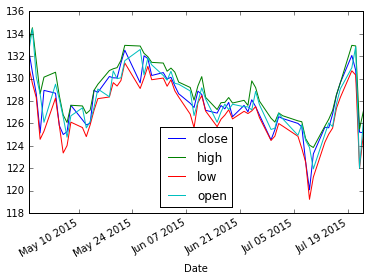

In [3]:
df.set_index('Date').plot()

Let's take advantage of this convenience and add a plot to our app.  To generate a plot output, we just need to add another dictionary to our list of outputs and override the `getPlot` method (which can return either a matplotlib figure or a matplotlib Axes object)

Since our inputs can only have one action_id and there are two outputs that need to be updated, we'll also add an update button to our app.

In [13]:
from spyre import server

import pandas as pd
import urllib2
import json

class StockExample(server.App):
    title = "Historical Stock Prices"

    inputs = [{     "type":'dropdown',
                    "label": 'Company', 
                    "options" : [ {"label": "Google", "value":"GOOG"},
                                  {"label": "Yahoo", "value":"YHOO"},
                                  {"label": "Apple", "value":"AAPL"}],
                    "key": 'ticker'}]

    controls = [{   "type" : "button",
                     "label":"get stock data",
                    "id" : "update_data"}]

    outputs = [{ "type" : "plot",
                    "id" : "plot",
                    "control_id" : "update_data"},
                { "type" : "table",
                    "id" : "table_id",
                    "control_id" : "update_data"}]

    def getData(self, params):
        ticker = params['ticker']
        # make call to yahoo finance api to get historical stock data
        api_url = 'https://chartapi.finance.yahoo.com/instrument/1.0/{}/chartdata;type=quote;range=3m/json'.format(ticker)
        result = urllib2.urlopen(api_url).read()
        data = json.loads(result.replace('finance_charts_json_callback( ','')[:-1])  # strip away the javascript and load json
        self.company_name = data['meta']['Company-Name']
        df = pd.DataFrame.from_records(data['series'])
        df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')
        return df.drop(['volume'],axis=1)

    def getPlot(self, params):
        df = self.getData(params)
        plt_obj = df.set_index('Date').plot()
        plt_obj.set_ylabel("Price")
        plt_obj.set_title(self.company_name)
        fig = plt_obj.get_figure()
        return fig

app = StockExample()
app.launch()

Finally we'll put each of the outputs in separate tabs and add an action_id to the dropdown input that references the "update_data" control. Now, a change to the input state triggers the button to be "clicked". This makes the existence of a "button" supurfluous, so we'll change the control type to "hidden"

In [17]:
from spyre import server

import pandas as pd
import urllib2
import json

class StockExample(server.App):
    title = "Historical Stock Prices"

    inputs = [{     "type":'dropdown',
                    "label": 'Company', 
                    "options" : [ {"label": "Google", "value":"GOOG"},
                                  {"label": "Yahoo", "value":"YHOO"},
                                  {"label": "Apple", "value":"AAPL"}],
                    "key": 'ticker', 
                    "action_id": "update_data"}]

    controls = [{   "type" : "hidden",
                    "id" : "update_data"}]

    tabs = ["Plot", "Table"]

    outputs = [{ "type" : "plot",
                    "id" : "plot",
                    "control_id" : "update_data",
                    "tab" : "Plot"},
                { "type" : "table",
                    "id" : "table_id",
                    "control_id" : "update_data",
                    "tab" : "Table" }]

    def getData(self, params):
        ticker = params['ticker']
        # make call to yahoo finance api to get historical stock data
        api_url = 'https://chartapi.finance.yahoo.com/instrument/1.0/{}/chartdata;type=quote;range=3m/json'.format(ticker)
        result = urllib2.urlopen(api_url).read()
        data = json.loads(result.replace('finance_charts_json_callback( ','')[:-1])  # strip away the javascript and load json
        self.company_name = data['meta']['Company-Name']
        df = pd.DataFrame.from_records(data['series'])
        df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')
        return df.drop('volume',axis=1)

    def getPlot(self, params):
        df = self.getData(params)
        plt_obj = df.set_index('Date').plot()
        plt_obj.set_ylabel("Price")
        plt_obj.set_title(self.company_name)
        fig = plt_obj.get_figure()
        return fig

app = StockExample()
app.launch()

<img src='two_outputs.png'>

## A few more things you can try

 - there's a "download" output type that uses either the getData method or a getDownload method
 - tables can be sortable. Just add a "sortable" key to the table output dictionary and set it's value to true
 - there are a couple of great Python libraries that produce JavaScript plots (Bokeh and Vincent). You can throw them into a getHTML method to add JavaScript plots to your spyre app (hoping to add a "bokeh" output type soon to make this integration a little easier).
 - you can link input values
 

## Deploying
 - Heroku ([blog post on setting up](http://adamhajari.github.io/2015/04/21/deploying-a-spyre-app-on-heroku.html), free!)
 - [pythonanywhere](https://www.pythonanywhere.com/) (free!)
 - Digital Ocean (\$5/month)
 - AWS (~\$10/month maybe?)

## More Examples On GitHub


## A couple of tricks
 - you can either name your output methods using the getType convention *or* you can have the name match the output id. This is useful if you've got multiple outputs of the same type.
 - if multiple outputs use the same data and it takes a long time to generate that data, there's a trick for caching data so you only have to load it once. See the stocks_example app in the examples directory of the git repo to see how (*Warning*: it's kind of hacky)